In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/mnt/kauffman/joosts/projects/STRT_epidermis/scripts'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from EPI_misc_scripts_v1_1 import *
from EPI_affinity_propagation_v1_0 import *
from EPI_neg_binom_regression_v1_1 import *
from EPI_pseudotemporal_ordering_v1_0 import *

Couldn't import dot_parser, loading of dot files will not be possible.


# Initialize engines

In [28]:
from ipyparallel import Client

In [29]:
c = Client(profile='default')

In [30]:
dview = c[:]

In [31]:
dview.execute('import sys')
dview.execute('sys.path.append("/mnt/kauffman/joosts/projects/STRT_epidermis/scripts")')
dview.execute('from EPI_misc_scripts_v1_1 import *')
dview.execute('from EPI_affinity_propagation_v1_0 import *')
dview.execute('from EPI_neg_binom_regression_v1_1 import *')
dview.execute('from EPI_pseudotemporal_ordering_v1_0 import *')

<AsyncResult: execute>

# Import Data

In [9]:
exp_id = '201509151726'
path_input = '/mnt/kauffman/joosts/projects/STRT_epidermis/data_input/v1.8'
path_output = '/mnt/kauffman/joosts/projects/STRT_epidermis/data_output/v1.8'

In [10]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')

In [11]:
meta = loadData_v1(path_input, exp_id, 'meta', 'DataFrame')

# 1st level clustering of whole dataset with Affinity Propagation

## Transform data for 1st level clustering and select features

In [12]:
seq_sel_1st = dropNull(seq, path_input, cutoff_mean = 0.05)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [13]:
len(seq_sel_1st.index)

9168

In [14]:
seq_sel_1st = cellCutoff(seq_sel_1st, 2000)


Removing cells with less than 2000 transcripts


In [15]:
len(seq_sel_1st.columns)

1422


Dropping unexpressed genes from dataset

After mean expression cutoff of 0.05, 9164 genes remain

After correlation cutoff of 5, 7123 genes remain

Optimization terminated successfully.
         Current function value: 1826.072511
         Iterations: 29
         Function evaluations: 53

After high variance feature selection, 2500 genes remain

Calculating binary logarithm of x + 1


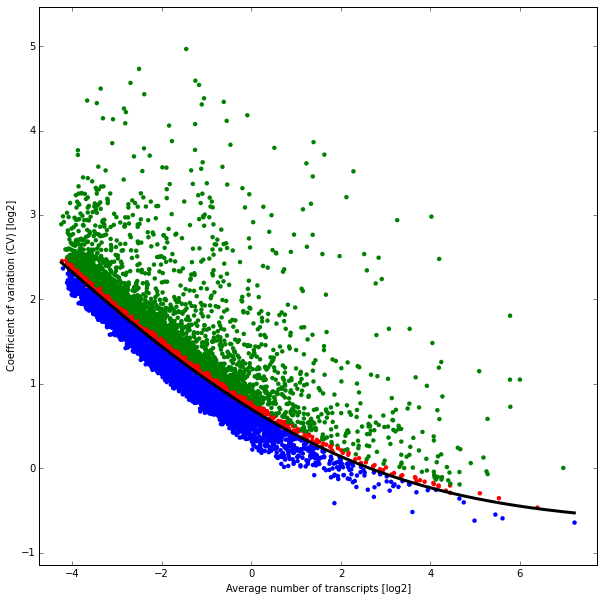

In [16]:
seq_sel_1st = select_features_v1(seq_sel_1st, 0.05, 5, 2500, path_input, percentile=95, return_all=False, drop_spikes = False, drop_repeats = False)

## Checkpoint

In [17]:
saveData_v1(seq_sel_1st, path_output, exp_id, 'seq_sel_1st')

In [19]:
seq_sel_1st = loadData_v1(path_output, exp_id, 'seq_sel_1st', 'DataFrame')

## Cluster cells I

In [29]:
preference = np.arange(-2.0, 0.0, 0.1)
damping = np.arange(0.5, 1.0, 0.05)

In [30]:
affy_s_1st = seq_sel_1st.corr()
dist_s_1st = 1 - affy_s_1st

          -2.0      -1.9      -1.8      -1.7      -1.6      -1.5      -1.4  \
0.50 -1105.349 -1104.756 -1102.523  -1107.08  -1107.08 -1103.022 -1107.101   
0.55 -1105.349 -1104.962 -1104.392 -1102.523 -1102.523 -1103.511 -1106.897   
0.60 -1105.349 -1103.161  -1107.08  -1107.08  -1100.85 -1101.731 -1102.784   
0.65 -1103.705 -1100.125 -1102.786 -1110.122 -1101.419 -1103.533 -1103.533   
0.70 -1104.392 -1104.392 -1098.487 -1104.392 -1102.731  -1104.85 -1097.255   
0.75 -1105.099 -1103.705  -1100.85 -1105.099 -1105.099 -1105.883 -1103.905   
0.80 -1105.099 -1105.099 -1105.099 -1105.099 -1105.099 -1105.883 -1101.723   
0.85  -1100.85  -1100.85  -1100.85  -1100.85  -1101.68  -1101.68  -1101.68   
0.90 -1105.099 -1105.099 -1105.099 -1105.099 -1105.883 -1105.883  -1101.68   
0.95 -1105.099 -1105.099 -1105.099 -1105.099 -1105.883 -1105.883 -1094.557   

          -1.3      -1.2      -1.1      -1.0      -0.9      -0.8      -0.7  \
0.50  -1099.01  -1100.56 -1098.105 -1097.097 -1094.555  -1097.4

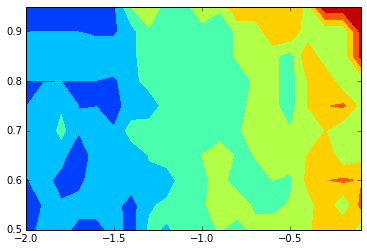

In [31]:
IC_s, Ng_s = AP_IC_v3P(seq_sel_1st, affy_s_1st, 0, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_s, Ng_s, plt.contourf(IC_s.columns, IC_s.index, IC_s)

In [32]:
pref_s, damp_s = AP_IC_findmin(IC_s)
print pref_s, damp_s

-1.7 0.65


In [33]:
s_groups_1st = AP_clustering_v3P(seq_sel_1st, affy_s_1st, 0, 'precomputed', pref_s, damp_s, path_scripts, linkage='single')

In [34]:
len(set(s_groups_1st))

13

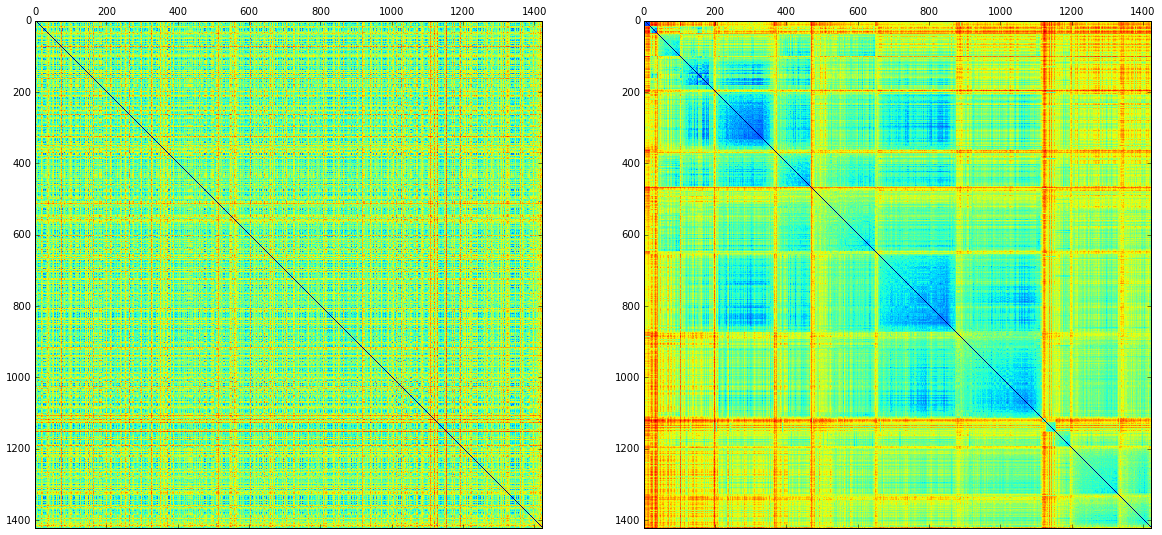

In [35]:
draw_AP_dist_mat(dist_s_1st, s_groups_1st)

## Cluster genes I

In [74]:
preference = np.arange(-5.0, -2.0, 0.1)
damping = np.arange(0.75, 0.95, 0.05)

In [75]:
affy_g_1st = seq_sel_1st.T.corr()
dist_g_1st = 1 - affy_g_1st

          -5.0      -4.9      -4.8      -4.7      -4.6      -4.5      -4.4  \
0.75       NaN -957.5228 -957.5228 -957.5228 -957.5228 -957.5228 -997.1403   
0.80 -921.9274 -957.5228 -957.5228 -957.5228 -957.5228 -957.5228 -997.1403   
0.85 -957.5228 -957.5228 -957.5228 -957.5228 -957.5228 -957.5228 -957.5228   
0.90 -957.5228 -957.5228 -957.5228 -957.5228 -957.5228 -957.5228 -957.5228   

          -4.3      -4.2      -4.1    ...         -3.0      -2.9      -2.8  \
0.75 -997.1403 -1010.936 -1010.936    ...    -1012.918 -1012.918 -1012.918   
0.80 -997.1403 -997.1403 -997.1403    ...    -961.2733 -961.2733 -961.2733   
0.85 -957.5228 -957.5228 -997.1403    ...    -1010.363 -1012.006 -1012.006   
0.90 -957.5228 -957.5228 -943.2988    ...    -1012.918 -1012.918 -1012.918   

          -2.7      -2.6      -2.5      -2.4      -2.3      -2.2      -2.1  
0.75 -1014.537 -1014.537   -1018.8 -1003.153 -999.5763 -1012.713 -1006.275  
0.80 -1017.686  -1000.71 -1015.492  -1000.71  -1000.71 -1012.713

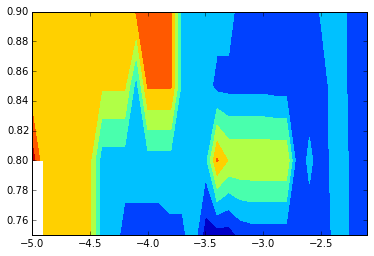

In [76]:
IC_g, Ng_g = AP_IC_v3P(seq_sel_1st, affy_g_1st, 1, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_g, Ng_g, plt.contourf(IC_g.columns, IC_g.index, IC_g)

In [77]:
pref_g, damp_g = AP_IC_findmin(IC_g)
print pref_g, damp_g

-3.4 0.75


In [79]:
g_groups_1st = AP_clustering_v3P(seq_sel_1st, affy_g_1st, 1, 'precomputed', pref_g, damp_g, path_scripts, linkage = 'single')

In [80]:
len(set(g_groups_1st))

18

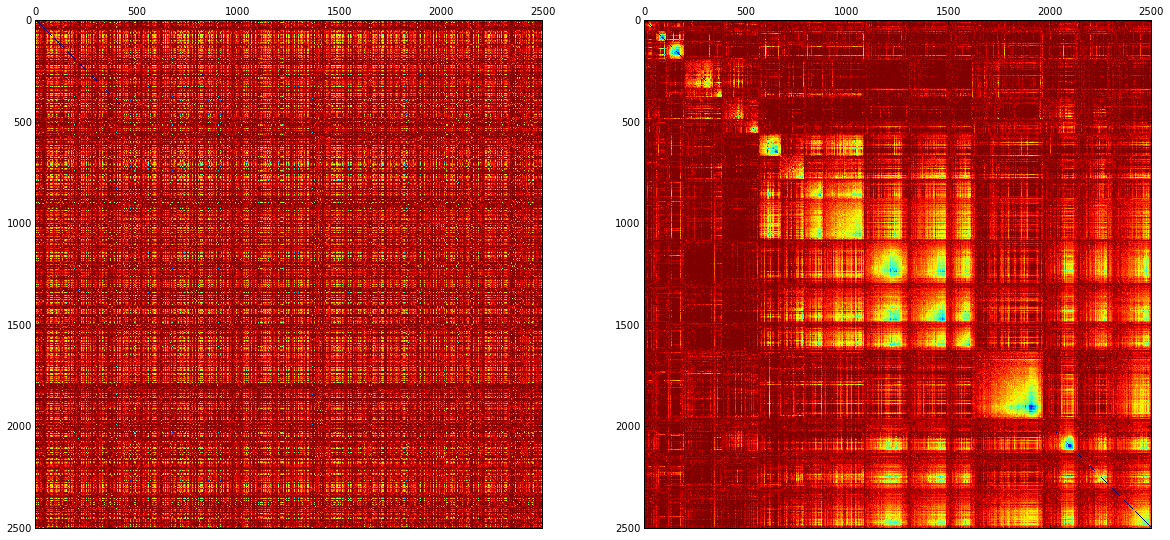

In [82]:
draw_AP_dist_mat(dist_g_1st, g_groups_1st)

## Draw heatmap I

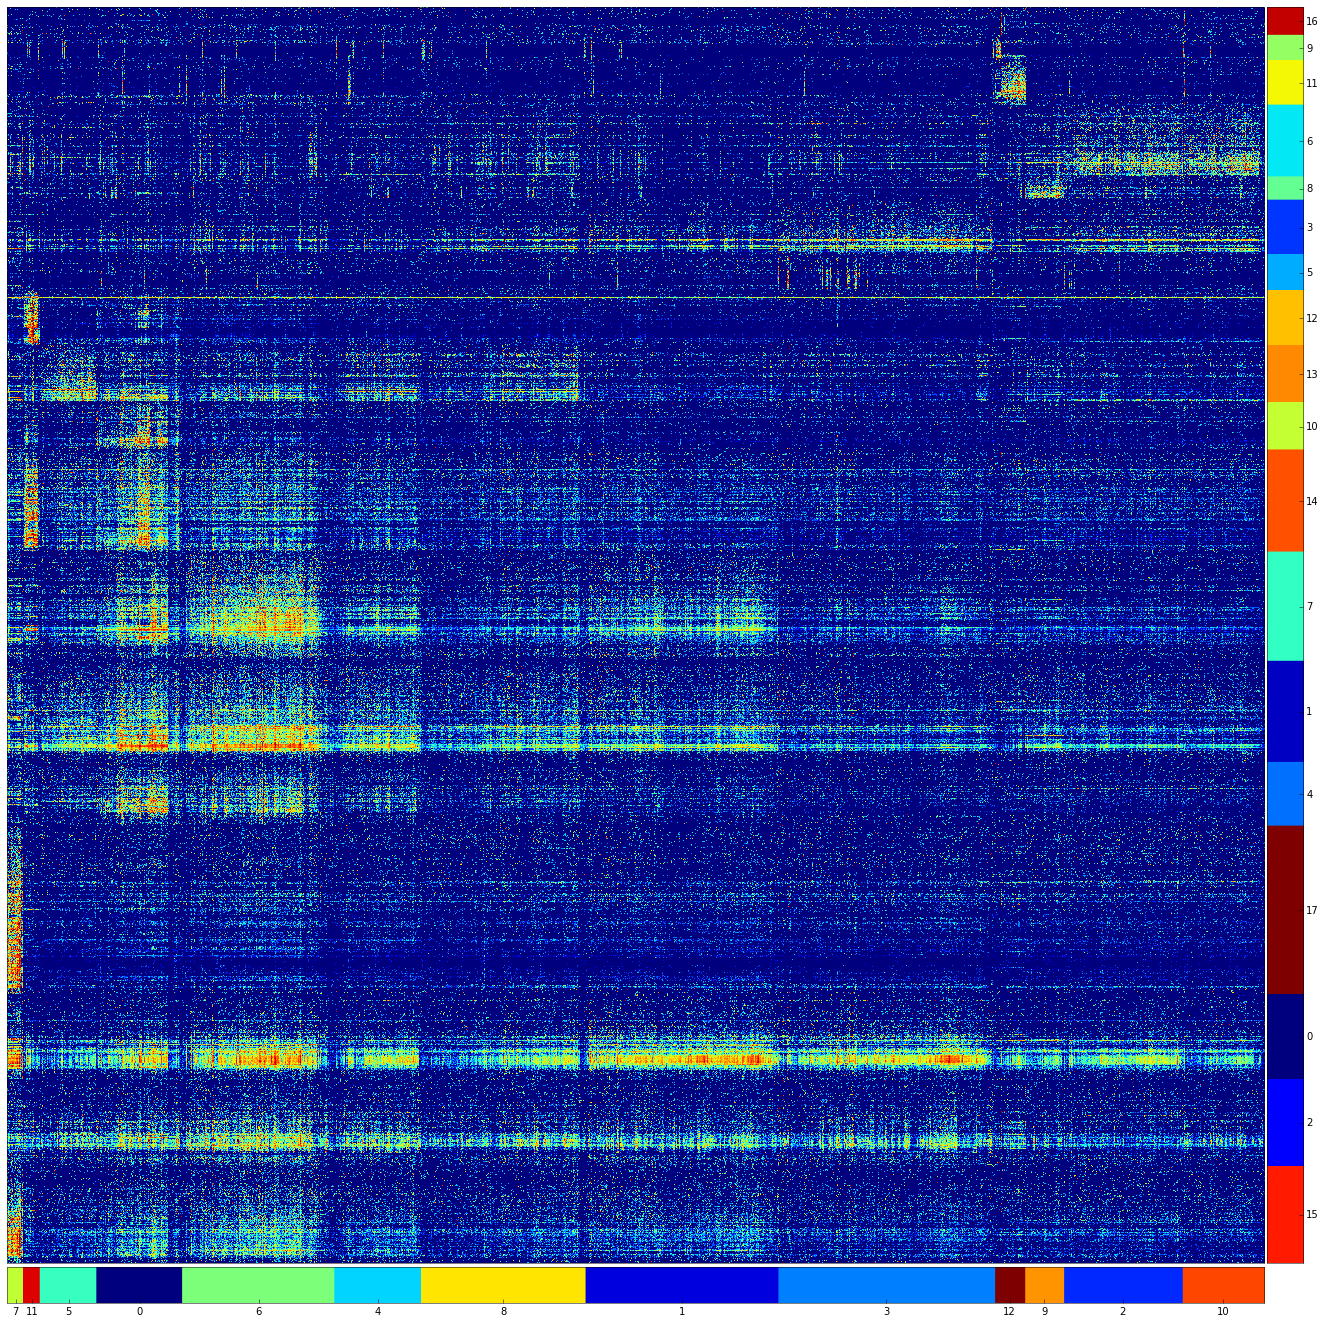

In [83]:
draw_heatmap(seq_sel_1st, s_groups_1st, g_groups_1st)

## Recluster samples without gene module 0 (translation and HKGs) and 2 (immediate early genes) to achieve better clustering of specific signatures

In [92]:
genes_select = g_groups_1st[~g_groups_1st.isin([0,2])].index

In [93]:
len(genes_select)

2158

In [94]:
seq_sel_1st_ = seq_sel_1st.ix[genes_select]

## Cluster cells II

In [95]:
preference = np.arange(-2.5, -0.5, 0.1)
damping = np.arange(0.5, 1.0, 0.05)

In [96]:
affy_s_1st_ = seq_sel_1st_.corr()
dist_s_1st_ = 1 - affy_s_1st_

          -2.5      -2.4      -2.3      -2.2      -2.1      -2.0      -1.9  \
0.50 -1220.241 -1221.238 -1221.238 -1225.278 -1225.278 -1227.301 -1227.301   
0.55 -1220.241 -1221.238 -1231.143 -1225.278 -1225.278 -1227.301 -1227.301   
0.60 -1220.241 -1221.238 -1221.238 -1235.249 -1225.278 -1227.301 -1227.301   
0.65 -1220.241 -1221.238 -1221.238 -1225.278 -1225.278 -1227.301 -1227.301   
0.70 -1221.238 -1221.238 -1221.238 -1225.278 -1225.278 -1227.301 -1227.072   
0.75 -1231.143 -1231.143 -1235.249 -1235.249 -1235.249 -1235.249 -1227.301   
0.80 -1221.238 -1221.238 -1221.238 -1221.238 -1221.238 -1222.914 -1222.914   
0.85 -1221.238 -1221.238 -1221.238 -1221.238 -1222.914 -1222.914 -1222.914   
0.90 -1221.238 -1221.238 -1222.914 -1222.914 -1222.914 -1222.914 -1222.914   
0.95 -1221.906 -1222.914 -1222.914 -1222.914 -1222.914 -1222.914 -1222.914   

          -1.8      -1.7      -1.6      -1.5      -1.4      -1.3      -1.2  \
0.50 -1227.301 -1227.301 -1227.301 -1227.301 -1230.234 -1226.21

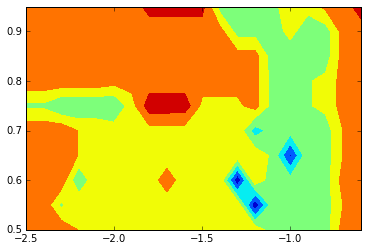

In [97]:
IC_s, Ng_s = AP_IC_v3P(seq_sel_1st_, affy_s_1st_, 0, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_s, Ng_s, plt.contourf(IC_s.columns, IC_s.index, IC_s)

In [98]:
pref_s, damp_s = AP_IC_findmin(IC_s)
print pref_s, damp_s

-1.3 0.6


In [119]:
s_groups_1st = AP_clustering_v3P(seq_sel_1st_, affy_s_1st_, 0, 'precomputed', -1.0, 0.65, path_scripts, linkage='single')

In [120]:
len(set(s_groups_1st))

16

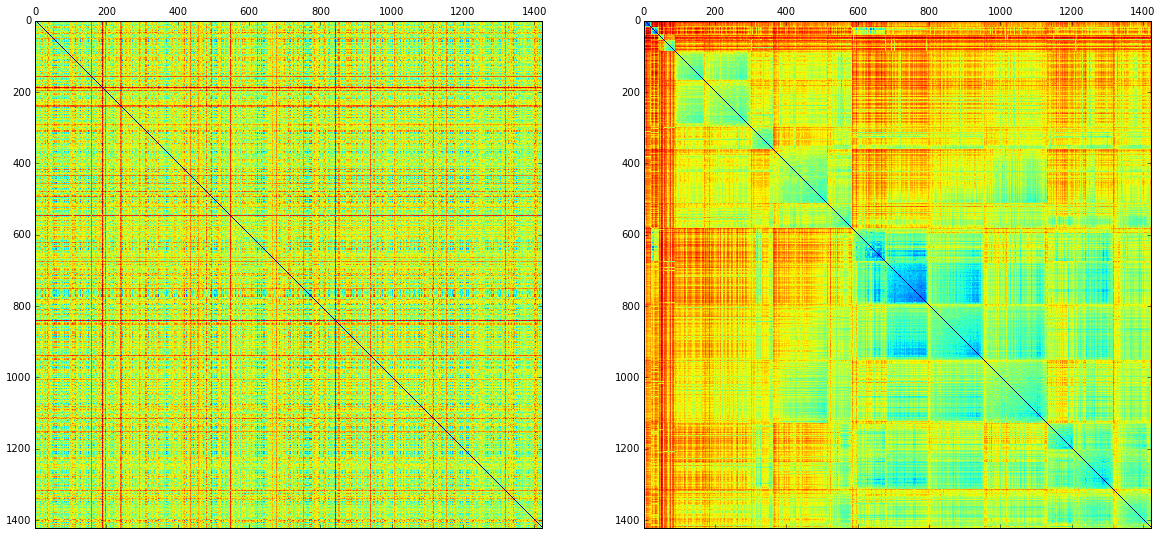

In [121]:
draw_AP_dist_mat(dist_s_1st_, s_groups_1st)

## Draw heatmap II

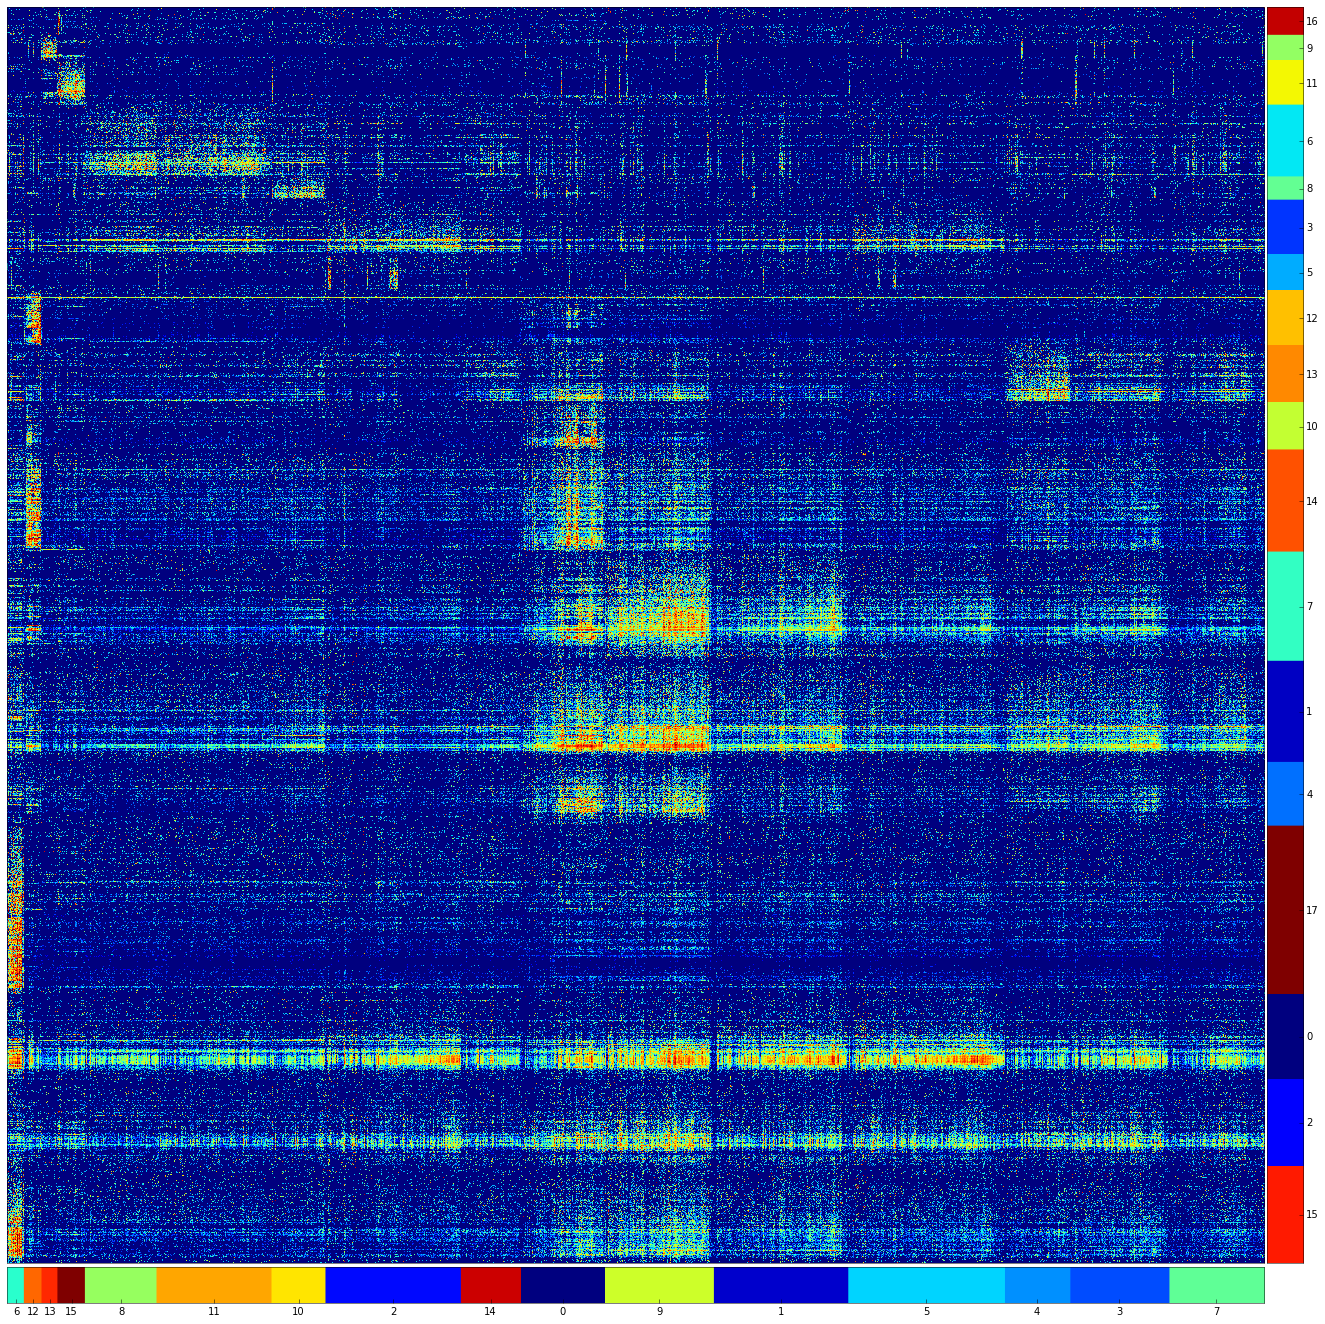

In [122]:
draw_heatmap(seq_sel_1st, s_groups_1st, g_groups_1st)

## To keep the complexity of the 1st level clustering limited, fuse the very similar outer bulge clusters (#8 + #11), basal upper HF clusters (#14 + #7) and basal IFE clusters (#2 + #5)

In [124]:
s_groups_1st = AP_fuse_clusters(seq_sel_1st_, s_groups_1st, 0, [8,11], linkage = 'single')

In [126]:
s_groups_1st = AP_fuse_clusters(seq_sel_1st_, s_groups_1st, 0, [7,13], linkage = 'single')

In [128]:
s_groups_1st = AP_fuse_clusters(seq_sel_1st_, s_groups_1st, 0, [2,5], linkage = 'single')

## Reorder groups according to spatial position from IFE to bulge (+ immune cells)

In [131]:
s_groups_1st = AP_groups_reorder(s_groups_1st, [2,1,8,0,10,6,3,4,5,7,9,11,12])

In [134]:
g_groups_1st = AP_groups_reorder(g_groups_1st, [3,5,1,7,4,10,14,12,13,15,17,6,8,9,11,16,2,0])

In [137]:
s_groups_1st = AP_invert_index(s_groups_1st, 2)

In [138]:
g_groups_1st = AP_invert_index(g_groups_1st, 17)

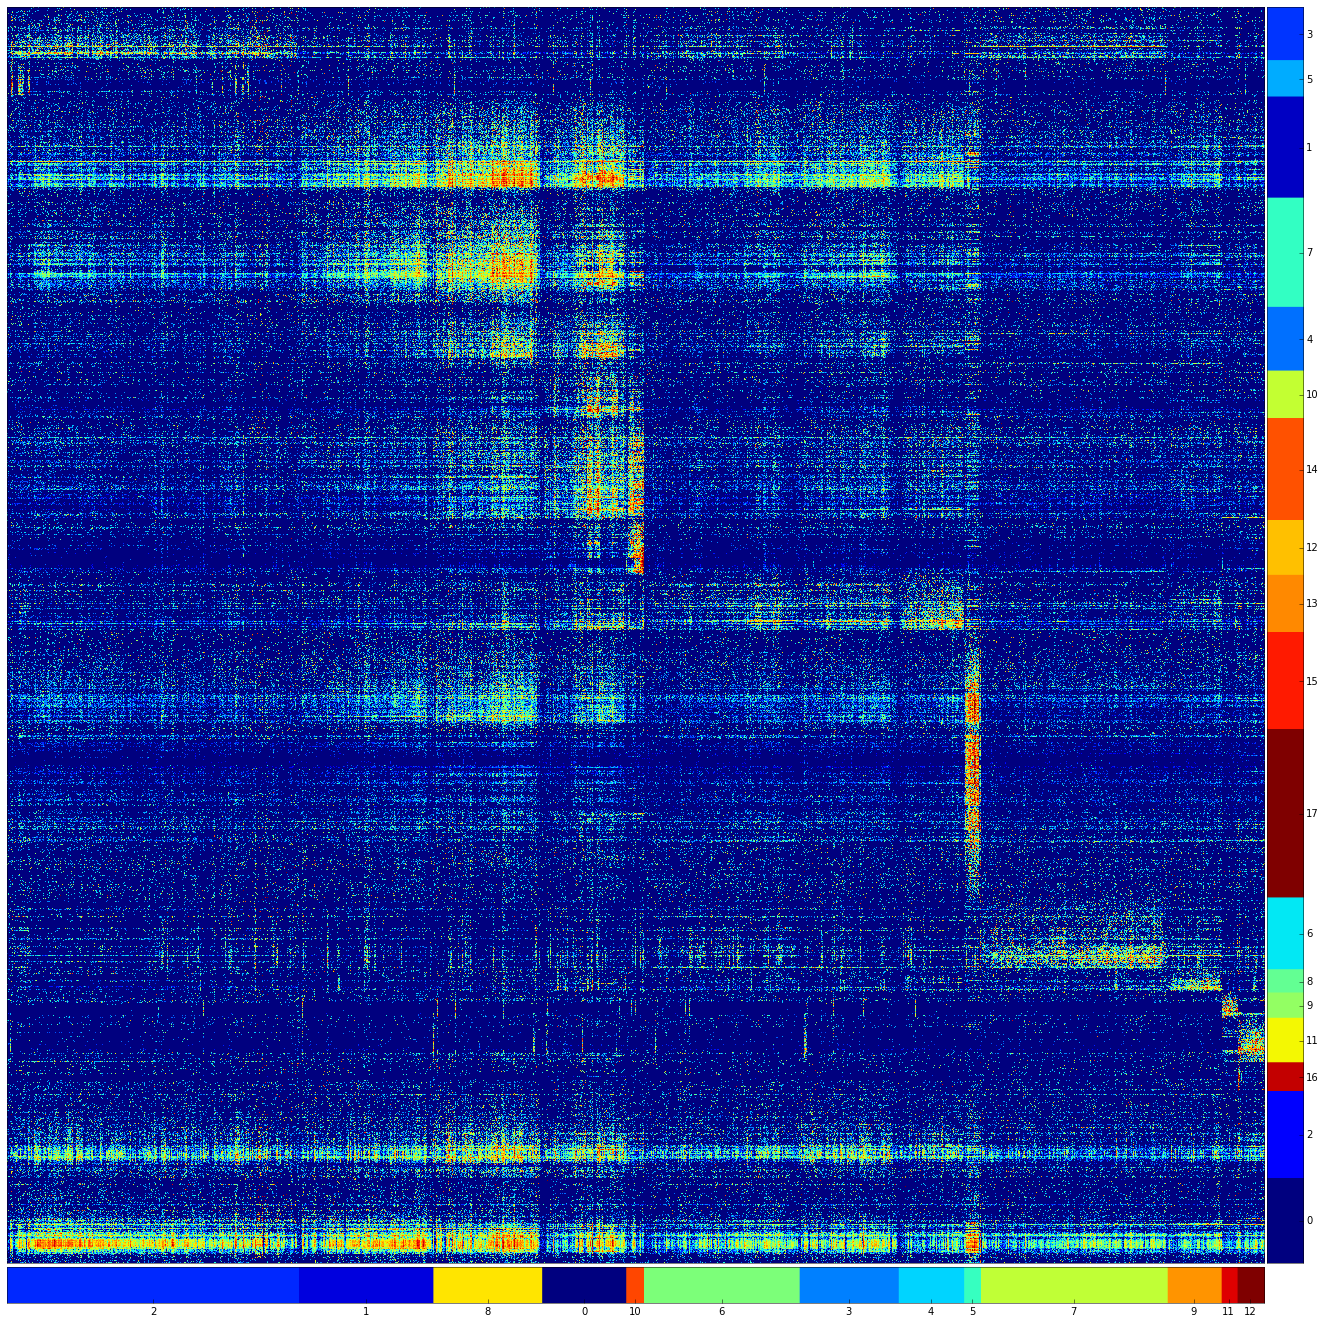

In [139]:
draw_heatmap(seq_sel_1st, s_groups_1st, g_groups_1st)

## Checkpoint

In [140]:
#saveData_v1(s_groups_1st, path_output, exp_id, 's_groups_1st')
#saveData_v1(g_groups_1st, path_output, exp_id, 'g_groups_1st')

In [12]:
s_groups_1st = loadData_v1(path_output, exp_id, 's_groups_1st', 'Series')
g_groups_1st = loadData_v1(path_output, exp_id, 'g_groups_1st', 'Series')

## Evaluate robustness

In [144]:
robustness_1st, robustness_1st_null = robustness_AP_v1P(seq_sel_1st_, 
                                                        s_groups_1st, 
                                                        seq_sel_1st_.index, 
                                                        0.75, 
                                                        100, 
                                                        -1.3, 
                                                        0.6, 
                                                        dview)

## Checkpoint

In [145]:
saveData_v1(robustness_1st, path_output, exp_id, 'robustness_1st')
saveData_v1(robustness_1st_null, path_output, exp_id, 'robustness_1st_null')

## Get t-SNE representation of whole dataset

In [146]:
from sklearn.manifold import TSNE

In [147]:
dist_mat_tsne = 1 - seq_sel_1st_.corr()

In [163]:
#tsne_coords = find_tSNE_v1P(dist_mat_tsne, s_groups_1st, 60, dview, perplexity=25, early_exaggeration=2.0, learning_rate=1000.0, 
                            #n_iter=1000, init='random', verbose=0, random_state=None)

In [164]:
#tsne_1st = tsne_coords[29]

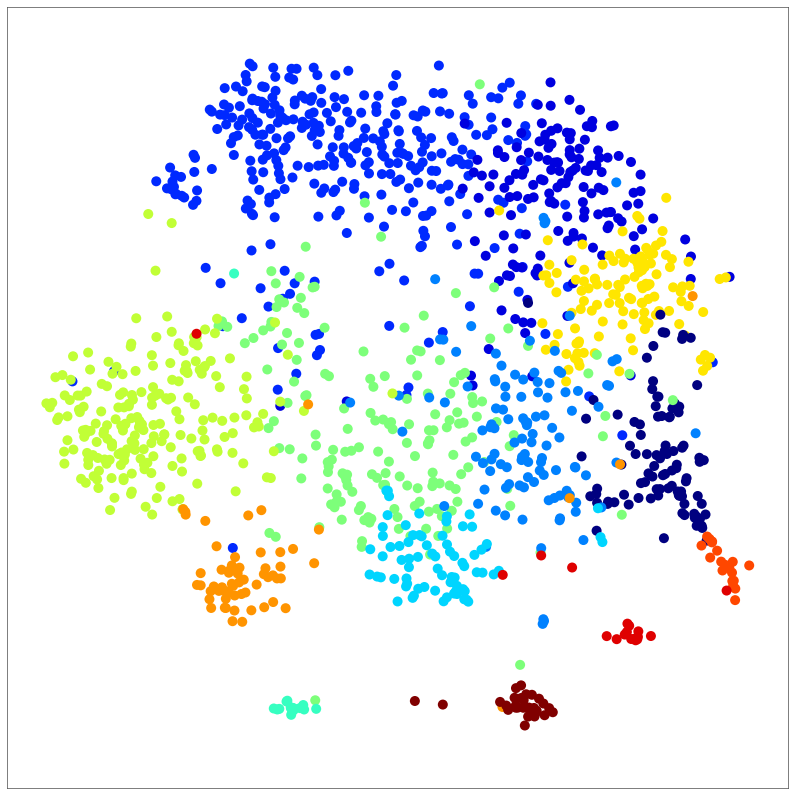

In [165]:
draw_tSNE(tsne_1st, s_groups_1st, '')

## Checkpoint

In [168]:
#saveData_v1(tsne_1st, path_output, exp_id, 'tsne_1st')

In [169]:
tsne_1st = loadData_v1(path_output, exp_id, 'tsne_1st', 'DataFrame')

# 1st level negative binominal regression model

## Define gene list to be used as input

In [12]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')
s_groups_1st = loadData_v1(path_output, exp_id, 's_groups_1st', 'Series')

In [13]:
seq_ = dropNull(seq[s_groups_1st.index], path_input, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [14]:
genes_sel_NBR_1st = NBR_select_genes_mean(seq_, s_groups_1st, cutoff = 0.25)

In [15]:
len(genes_sel_NBR_1st)

9016

## Fit model

In [21]:
"""
NBR_1st_traces = neg_binom_regression_v2P(seq_, 
                                          s_groups_1st, 
                                          genes_sel_NBR_1st, 
                                          path_output, 
                                          exp_id, 
                                          'NBR_1st_traces', 
                                          4600, 
                                          dview, 
                                          iter=275, 
                                          chains=4, 
                                          warmup=25,
                                          n_jobs=4)
"""

4600 / 9016
9016 / 9016


## Checkpoint

In [22]:
NBR_1st_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_1st_traces')

## Get summary statistics and test against Baseline / other groups

In [23]:
NBR_1st_summary = neg_binom_summary_stats_v1P(NBR_1st_traces, dview)
NBR_1st_bin_bl, NBR_1st_size_bl = neg_binom_vs_baseline_v1P(NBR_1st_summary, dview)
NBR_1st_bin_gr, NBR_1st_size_gr = neg_binom_vs_groups_v1P(NBR_1st_summary, dview)

## Checkpoint

In [24]:
#saveData_to_pickle_v1(NBR_1st_summary, path_output, exp_id,'NBR_1st_summary')
#saveData_to_pickle_v1(NBR_1st_bin_bl,path_output,exp_id,'NBR_1st_bin_bl')
#saveData_to_pickle_v1(NBR_1st_size_bl,path_output,exp_id,'NBR_1st_size_bl')
#saveData_to_pickle_v1(NBR_1st_bin_gr,path_output,exp_id,'NBR_1st_bin_gr')
#saveData_to_pickle_v1(NBR_1st_size_gr,path_output,exp_id,'NBR_1st_size_gr')

In [18]:
NBR_1st_summary = loadData_from_pickle_v1(path_output, exp_id,'NBR_1st_summary')
NBR_1st_bin_bl = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_bin_bl')
NBR_1st_size_bl = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_size_bl')
NBR_1st_bin_gr = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_bin_gr')
NBR_1st_size_gr = loadData_from_pickle_v1(path_output,exp_id,'NBR_1st_size_gr')